# Пункт 1. Реализовать стохастический градиентный спуск

In [401]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from numpy import linalg as LA

# # suppress warnings
# import warnings
# warnings.filterwarnings("ignore")

In [402]:
DEFAULT_LR = 0.005

In [403]:
# linear function, computes k-th coordinate by k-1 first
#   coefficients - k-1-dim array
#   x - k-1-dim array
def f(coefficients, x, coefficient_bound = 0):
    return np.sum(coefficients * x) + coefficient_bound * (2 * np.random.random_sample() - 1)

# scale coord array into [0; 1] interval
def scale_dim(coords):
    mn = coords[0]
    mx = coords[0]
    for i in range(0, len(coords)):
        mn = min(mn, coords[i])
        mx = max(mx, coords[i])
    if mn == mx:
        for i in range(0, len(coords)):
            coords[i] = 0
    else:
        for i in range(0, len(coords)):
            coords[i] = (coords[i] - mn) / (mx - mn)
    return [coords, mn, mx]

# scale all point_set coords into [0; 1] interval
def apply_scaling(points):
    x = points.x.copy()
    y = points.y.copy()
    for k in range(0, points.dim - 1):
        coords = np.asarray([])
        for i in range(0, points.n):
            coords = np.append(coords, points.x[i][k])
        coords = scale_dim(coords)[0]
        for i in range(0, points.n):
            x[i][k] = coords[i]
    y = scale_dim(y)[0] 
    return point_set(points.n, points.dim, x, y, 1)

class point_set:
    # copy ctor :|
    def __init__(self, n, dim, x, y, coords_bound = 0):
        self.n = n
        self.dim = dim
        self.x = np.asarray(x, dtype=np.float64)
        self.y = np.asarray(y, dtype=np.float64)
        self.coords_bound = coords_bound

# create point_set:
# n - amount of points
# dim - space's dim
# coords_bound - upper bound on absolute first k-1 coordinates value
# coefficients_bound - upper bound on absolute coefficients value
def create_point_set(n, dim, coords_bound, coefficients_bound, specified_func, coefficients = []):
    x = coords_bound * np.random.random_sample((n, dim - 1))
    if coefficients == []:
        coefficients = coefficients_bound * np.random.random_sample((dim - 1)) - coefficients_bound
    else:
        coefficients = np.asarray(coords_bound)

    y = np.asarray([])
    for i in range(0, n):
        y = np.append(y, specified_func([f(coefficients, x[i], coefficients_bound)]))
    # y = coords_bound * np.random.random_sample((n))
    return point_set(n, dim, x, y, coords_bound)


def f1(x):
    return sin(x[0]) + cos(x[0])

def f2(x):
    return 3.2 * sin(x[0]) + 1.7 * x[0] * cos(x[0])

def f3(x):
    return x[0]**4 + 404 * x[0] ** 2 + 123 

EPOCH_MAX = 50

input_f1 = create_point_set(100, 2, 20., 10., f1)
input_f2 = create_point_set(100, 2, 20., 10., f2)
input_f3 = create_point_set(100, 2, 20., 10., f3)


In [404]:
# considered loss function for points_set
# f = sum from i=0 to n-1 of (a*x_i + b - y_i)^2, where a.append(b) = c
#   points - point_set
#   c - k-dim array of coefficients points = [a_0, ..., a_k-2, b]
# def loss_function(points, c):
#     f = 0
#     for i in range(0, points.n):
#         f += (np.asarray(c[0 : points.dim - 1], dtype=np.float64) @ points.x[i] + c[points.dim - 1] - points.y[i]) ** 2
#     return f
def loss_function(points, coeffs, i):
    return 1 / (points.n) * np.square(coeffs[points.dim - 1] + np.sum(coeffs[0 : points.dim - 1] * points.x[i]) - points.y[i]) 

In [405]:
def gradient_compute(points, coeffs, id, h=1e-5):
    dim = points.dim
    grad = np.asarray([0.] * dim)
    step = np.asarray([0.] * dim)
    for i in range(0, dim):
        step[i] = h
        grad[i] = (loss_function(points, coeffs + step, id) - loss_function(points, coeffs - step, id)) / (2 * h)
        step[i] = 0
    return grad

# calculate gradient [d/da, d/db] of loss function for points_set by variables x_i, where i in ids
#   points - point_set
#   ids - array of indices for taking gradient
#   coeffs - current loss function = [a_0, ..., a_k-2, b]
def loss_function_grad(points, ids, coeffs):
    result = np.asarray([0.] * points.dim)
    for i in ids:
        result += gradient_compute(points, coeffs, i)
    return result

In [406]:
# stochastic gradient descent
#   point - point_set
#   batch_size - amount of variables for diff in one epoch
#   gradinet_supplier - :)
#   starting_coeffs - array of point.dim len
#   lr - function (current_lr, epoch)
#   eps - :)
#   epoches - max amount of epoches
#   _param - ignored
# ret:
#   [
#       found coeffs - array of point.dim len,
#       history - array of all epoches changes
#   ]
def sgd(points, batch_size, gradinet_supplier, starting_coeffs, lr, eps, epoches, _param_1, _param_2):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    current_lr = DEFAULT_LR
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index : to], coeffs)
        coeffs_step = coeffs - current_lr * np.asarray(grad)

        # print(coeffs_step)
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

In [407]:
constant_lr = (lambda current_lr, epoch: DEFAULT_LR)
def step_decay(lr, epoch, epochs_drop = 20, drop = 0.5):
   return lr * pow(drop, floor((1 + epoch) / epochs_drop))
   
colors = ["blue", "red", "green", "orange", "purple", "yellow", "pink", "brown", "black", "magenta"]

# call sgd with each possible batch_size for point_set
#   lr - function (current_lr, epoch)
def batch_size_analyze(points, lr = constant_lr, gd = sgd, param_1 = 0, param_2 = 0):
    epoches = np.asarray([])
    for batch in range(1, points.n + 1):
        result = gd(points, batch, loss_function_grad, np.asarray([0.] * (points.dim)), lr, 1e-6, EPOCH_MAX, param_1, param_2)
        epoches = np.append(epoches, len(result[1]))    
    return epoches

# print batch_size_analyze(points, lr)
def print_batch_size_analyze(points, lr = constant_lr, gd = sgd, name='minibatch SGD', params_1 = [0], params_2 = [0]):
    if params_1 == [0] and params_2 == [0]:
        epoches = batch_size_analyze(points, lr, gd = gd, param_1 = 0)
        plt.plot(np.linspace(1, len(epoches), len(epoches)), epoches)
    if params_1 != [0] and params_2 == [0]:
        for i in range(0, len(params_1)):
            epoches = batch_size_analyze(points, lr, gd = gd, param_1 = params_1[i])
            plt.plot(np.linspace(1, len(epoches), len(epoches)), epoches, color = colors[i % len(colors)], label = "parameter=" + str(params_1[i]))
        plt.legend()
    if params_1 != [0] and params_2 != [0]:
        for i in range(0, len(params_1)):
            for j in range (0, len(params_2)):
                epoches = batch_size_analyze(points, lr, gd = gd, param_1 = params_1[i], param_2 = params_2[j])
                plt.plot(np.linspace(1, len(epoches), len(epoches)), epoches, color = colors[(i*len(params_2)+j) % len(colors)], label = str(params_1[i])+ " " + str(params_2[j])) 
            plt.legend()
    plt.xlabel("batch")
    plt.ylabel("epoches")
    plt.title(name + " for n=" + str(points.n) + ", dim=" + str(points.dim) + ", coords<=" + str(points.coords_bound))
    plt.show()

In [408]:
def apply_all_loss_functions(points, coeffs):
    result = 0.
    for i in range(0, points.dim):
        result += loss_function(points, coeffs, i)
    return result

# draw loss func values by epoch for point_set & given batch
#   lr - function (current_lr, epoch)
def print_loss_function_epochs(points, batch, lr = constant_lr, gd = sgd, name = 'minibatch SGD', param = 0, p = 0):
    result = gd(points, batch, loss_function_grad, np.asarray([0.] * (points.dim)), lr, 1e-6, EPOCH_MAX, param, p)

    loss_func_values = np.asarray([])
    for coeffs in result[1]:
        loss_func_values = np.append(loss_func_values, [apply_all_loss_functions(points, coeffs)])
        
    plt.plot(loss_func_values)
    plt.xlabel("epoch")
    plt.ylabel("loss function value")
    plt.title("loss function by " + name + " for n=" + str(points.n) + ", dim=" + str(points.dim) + ", coords<=" + str(points.coords_bound))
    plt.show()

In [409]:
def print_2d_epoches(points, lr, gd, param_1, param_2):
    result = gd(points, points.n // 2, loss_function_grad, np.asarray([0.] * (points.dim)), lr, 1e-6, EPOCH_MAX, param_1, param_2)
    print("epoches: ", len(result[1]))
    print("loss: ", apply_all_loss_functions(points, result[0]))
    print("coeffs: y =", result[0][1], "* x +", result[0][0])
    return result

def print_2d_result(points, lr = constant_lr, gd = sgd, param_1 = 0, param_2 = 0):
    result = print_2d_epoches(points, lr, gd, param_1, param_2)
    plt.plot(points.x, points.y, 'o', markersize=1)
    grid = np.linspace(np.min(points.x), np.max(points.x), 1000)
    plt.title('Point set and evaluated function')
    plt.plot(grid, result[0][0] * grid + result[0][1])
    plt.show()

epoches:  31
loss:  0.02138422510788587
coeffs: y = 0.010156281599852823 * x + 8.440863716142111e-05


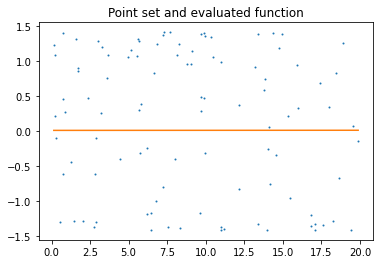

epoches:  33
loss:  9.727559369749672
coeffs: y = 0.30028232412767797 * x + -0.27335731883728487


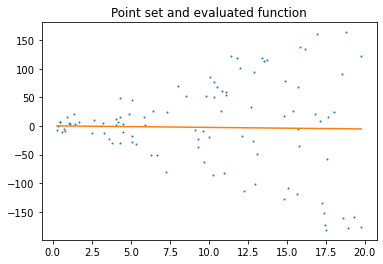

epoches:  43
loss:  124210830.8844473
coeffs: y = -108.6240230619119 * x + 8930.53857267924


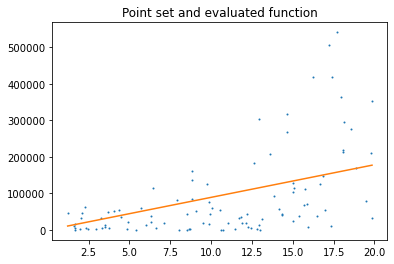

In [410]:
print_2d_result(input_f1, step_decay, sgd)
print_2d_result(input_f2, step_decay, sgd)
print_2d_result(input_f3, step_decay, sgd)

### SGD with momentum

In [411]:
# stochastic gradient descent with momentum
#   point - point_set
#   batch_size - amount of variables for diff in one epoch
#   gradinet_supplier - :)
#   starting_coeffs - array of point.dim len
#   lr - function (current_lr, epoch)
#   eps - :)
#   epoches - max amount of epoches
#   betta - parameter
# ret:
#   [
#       found coeffs - array of point.dim len,
#       history - array of all epoches changes
#   ]
def sgd_with_momentum(points, batch_size, gradinet_supplier, starting_coeffs, lr, eps, epoches, betta, param_2):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    coeffs = starting_coeffs
    current_lr = DEFAULT_LR
    grad = gradinet_supplier(points, order[0 : batch_size], coeffs)
    batch_index = batch_size % points.n
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = betta * grad + (1 - betta) * gradinet_supplier(points, order[batch_index:to], coeffs)
        coeffs_step = coeffs - current_lr * grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

epoches:  28
loss:  0.024213204003445215
coeffs: y = 0.010417358055053729 * x + 0.0054891868490603585


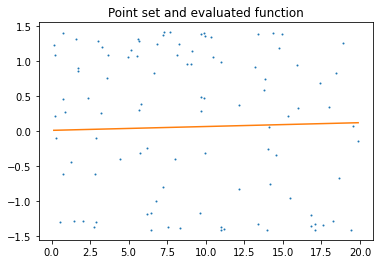

epoches:  35
loss:  11.049756214389747
coeffs: y = 0.31479092115343876 * x + -0.40353292408923214


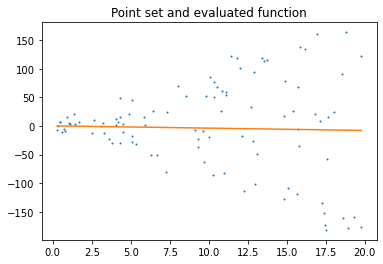

epoches:  42
loss:  110701728.75515898
coeffs: y = -167.5823969149251 * x + 8602.821509816606


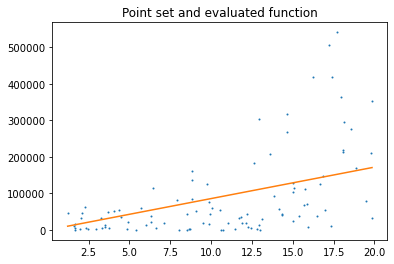

In [412]:
print_2d_result(input_f1, step_decay, sgd_with_momentum)
print_2d_result(input_f2, step_decay, sgd_with_momentum)
print_2d_result(input_f3, step_decay, sgd_with_momentum)

### SGD with Nesterov momentum

In [413]:
# calculate gradient [d/da, d/db] of loss function for points_set by variables x_i, where i in ids
#   points - point_set
#   ids - array of indices for taking gradient
#   coeffs - current loss function = [a_0, ..., a_k-2, b]
#   betta - parameter
#   grad - previous step gradined
def nesterov_loss_function_grad(points, ids, coeffs, betta, grad):
    result = np.asarray([0.] * points.dim)
    for i in ids:
        result += gradient_compute(points, coeffs - betta * grad, i)
    return result

# stochastic gradient descent with Nesterov momentum
#   point - point_set
#   batch_size - amount of variables for diff in one epoch
#   _gradinet_supplier - ignored
#   starting_coeffs - array of point.dim len
#   lr - function (current_lr, epoch)
#   eps - :)
#   epoches - max amount of epoches
#   betta - parameter
# ret:
#   [
#       found coeffs - array of point.dim len,
#       history - array of all epoches changes
#   ]
def sgd_with_nesterov_momentum(points, batch_size, _gradinet_supplier, starting_coeffs, lr, eps, epoches, betta, gamma):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    current_lr = DEFAULT_LR
    coeffs = starting_coeffs
    # grad = np.asarray([0] * points.dim)
    grad = _gradinet_supplier(points, order[0 : batch_size], coeffs)
    batch_index = batch_size % points.n

    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = betta * grad + current_lr * nesterov_loss_function_grad(points, order[batch_index:to], coeffs, betta, grad)
        coeffs_step = coeffs - grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

epoches:  31
loss:  0.02071365463630835
coeffs: y = 0.06783089852332685 * x + -0.0053622877279960535


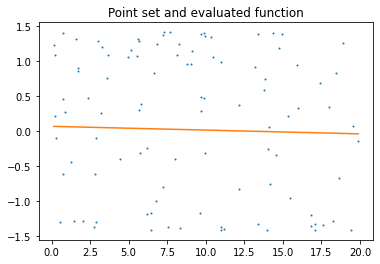

epoches:  38
loss:  12.687600804241418
coeffs: y = 4.25485052744448 * x + -0.8328332036268552


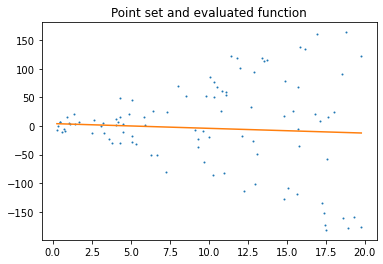

epoches:  44
loss:  121703675.11861034
coeffs: y = -426.5049839230345 * x + 8890.560797945487


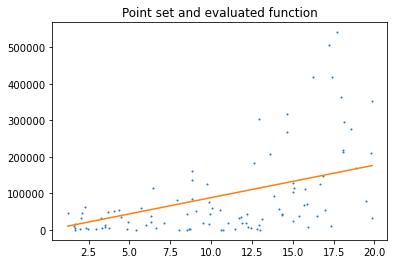

In [414]:
print_2d_result(input_f1, step_decay, sgd_with_nesterov_momentum, 0.35)
print_2d_result(input_f2, step_decay, sgd_with_nesterov_momentum, 0.35)
print_2d_result(input_f3, step_decay, sgd_with_nesterov_momentum, 0.35)